In [35]:
import tensorflow as tf 
from tensorflow.keras import models,layers
import numpy as np
import pandas as pd

In [36]:
num_classes = 10

learning_rate = 0.001
training_steps = 200
batch_size = 100
display_step = 10

conv1_filters = 32 # number of filters for 1st conv layer.
conv2_filters = 64 # number of filters for 2nd conv layer.
fc1_units = 1024 # number of neurons for 1st fully-connected layer.

In [37]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [38]:
random_normal = tf.initializers.RandomNormal()

weights = {
    # Conv Layer 1: 5x5 conv, 1 input, 32 filters (MNIST has 1 color channel only).
    'wc1': tf.Variable(random_normal([5, 5, 1, conv1_filters])),
    # Conv Layer 2: 5x5 conv, 32 inputs, 64 filters.
    'wc2': tf.Variable(random_normal([5, 5, conv1_filters, conv2_filters])),
    # FC Layer 1: 7*7*64 inputs, 1024 units.
    'wd1': tf.Variable(random_normal([7*7*64, fc1_units])),
    # FC Out Layer: 1024 inputs, 10 units (total number of classes)
    'out': tf.Variable(random_normal([fc1_units, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([conv1_filters])),
    'bc2': tf.Variable(tf.zeros([conv2_filters])),
    'bd1': tf.Variable(tf.zeros([fc1_units])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [39]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation.
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper.
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
# ADAM optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = conv_net(x)
        loss = cross_entropy(pred, y)
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [40]:
def conv_net(x):
    
    # Input shape: [-1, 28, 28, 1]. A batch of 28x28x1 (grayscale) images.
    x = tf.reshape(x, [-1, 28, 28, 1])

    # Convolution Layer. Output shape: [-1, 28, 28, 32].
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 14, 14, 32].
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer. Output shape: [-1, 14, 14, 64].
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 7, 7, 64].
    conv2 = maxpool2d(conv2, k=2)
    # Reshape conv2 output to fit fully connected layer input, Output shape: [-1, 7*7*64].
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer, Output shape: [-1, 1024].
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    # Apply ReLU to fc1 output for non-linearity.
    fc1 = tf.nn.relu(fc1)

    # Fully connected layer, Output shape: [-1, 10].
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out)

def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [41]:
Accc = []
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    pred = conv_net(batch_x)
    acc = accuracy(pred, batch_y)
    Accc.append(float(acc))
    if step % display_step == 0:
        #pred = conv_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        #acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 56.204979, accuracy: 0.860000
step: 20, loss: 39.494549, accuracy: 0.880000
step: 30, loss: 45.609734, accuracy: 0.860000
step: 40, loss: 34.077576, accuracy: 0.900000
step: 50, loss: 11.486303, accuracy: 0.970000
step: 60, loss: 13.615742, accuracy: 0.980000
step: 70, loss: 24.743710, accuracy: 0.940000
step: 80, loss: 18.097584, accuracy: 0.930000
step: 90, loss: 10.342843, accuracy: 0.950000
step: 100, loss: 8.409833, accuracy: 0.970000
step: 110, loss: 5.030828, accuracy: 0.990000
step: 120, loss: 8.587709, accuracy: 0.970000
step: 130, loss: 12.211029, accuracy: 0.970000
step: 140, loss: 11.351440, accuracy: 0.960000
step: 150, loss: 4.960558, accuracy: 1.000000
step: 160, loss: 7.976833, accuracy: 0.980000
step: 170, loss: 6.689782, accuracy: 0.990000
step: 180, loss: 3.766511, accuracy: 0.990000
step: 190, loss: 9.504124, accuracy: 0.960000
step: 200, loss: 2.279022, accuracy: 1.000000


Text(0, 0.5, 'accuracy')

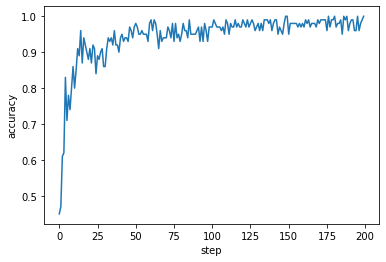

In [42]:
import matplotlib.pyplot as plt
plt.plot(Accc)
plt.xlabel('step')
plt.ylabel('accuracy')


In [43]:
pred = conv_net(x_test)
loss = cross_entropy(pred,y_test)
acc = accuracy(pred, y_test)
print(float(acc))

0.9782999753952026


In [ ]:
#CNN + SVM

In [44]:
random_normal = tf.initializers.RandomNormal()

weights = {
    # Conv Layer 1: 5x5 conv, 1 input, 32 filters (MNIST has 1 color channel only).
    'wc1': tf.Variable(random_normal([5, 5, 1, conv1_filters])),
    # Conv Layer 2: 5x5 conv, 32 inputs, 64 filters.
    'wc2': tf.Variable(random_normal([5, 5, conv1_filters, conv2_filters])),
    # FC Layer 1: 7*7*64 inputs, 1024 units.
    'wd1': tf.Variable(random_normal([7*7*64, fc1_units])),
    # FC Out Layer: 1024 inputs, 10 units (total number of classes)
   ###'out': tf.Variable(random_normal([fc1_units, num_classes])),
    'SVM': tf.Variable(random_normal([fc1_units,num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([conv1_filters])),
    'bc2': tf.Variable(tf.zeros([conv2_filters])),
    'bd1': tf.Variable(tf.zeros([fc1_units]))
    #'out': tf.Variable(tf.zeros([num_classes])),
}

In [45]:
def conv_net_2(x):
    x = tf.reshape(x, [-1, 28, 28, 1])                                       # Input shape: [-1, 28, 28, 1].
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])                         #Output shape: [-1, 28, 28, 32].
    conv1 = maxpool2d(conv1, k=2)
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])   #Output shape: [-1, 7*7*64].
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])              #Output shape: [-1, 1024].
    fc2 = tf.nn.dropout(fc1, rate = 0.5 )
    svm = tf.matmul(fc2, weights['SVM'])
    return svm


def soft_margin(y_pred, y_true):
    regularization_loss = tf.math.reduce_sum(tf.square(weights['SVM'])) 
    y_true = 2*tf.one_hot(y_true, depth=num_classes)-1                           
    hinge_loss = tf.math.reduce_sum(
        tf.square(
            tf.maximum(
                tf.zeros([batch_size, num_classes]), 
                1 - y_true * y_pred)
        )
    )
    return tf.add(regularization_loss, 2 * hinge_loss)
 
    
def accuracy_2(y_pred, y_true):
    y_pred = tf.identity(y_pred, name="prediction")
    #y_true = tf.one_hot(y_true, depth=num_classes)
    correct_prediction = tf.equal(tf.argmax(y_pred, 1),tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

def run_optimization_2(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = conv_net_2(x)
        loss = soft_margin(pred, y)
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [46]:
optimizer = tf.optimizers.Adam(learning_rate)

In [47]:
training_steps = 200
learning_rate = 0.01
Accc = []
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization_2(batch_x, batch_y)
    pred = conv_net_2(batch_x)
    acc = accuracy_2(pred, batch_y)
    Accc.append(acc)
    if step % 10 == 0:
        loss = soft_margin(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 777.881226, accuracy: 0.450000
step: 20, loss: 408.904968, accuracy: 0.760000
step: 30, loss: 260.407227, accuracy: 0.840000
step: 40, loss: 226.390503, accuracy: 0.890000
step: 50, loss: 155.600464, accuracy: 0.930000
step: 60, loss: 91.975952, accuracy: 0.970000
step: 70, loss: 139.197327, accuracy: 0.910000
step: 80, loss: 119.707985, accuracy: 0.940000
step: 90, loss: 78.168526, accuracy: 0.990000
step: 100, loss: 128.023788, accuracy: 0.920000
step: 110, loss: 116.643806, accuracy: 0.950000
step: 120, loss: 143.887405, accuracy: 0.930000
step: 130, loss: 102.554192, accuracy: 0.970000
step: 140, loss: 85.012497, accuracy: 0.960000
step: 150, loss: 84.874001, accuracy: 0.990000
step: 160, loss: 91.092850, accuracy: 0.990000
step: 170, loss: 68.741562, accuracy: 0.990000
step: 180, loss: 60.080868, accuracy: 1.000000
step: 190, loss: 62.240276, accuracy: 0.980000
step: 200, loss: 73.072891, accuracy: 0.960000


Text(0, 0.5, 'accuracy')

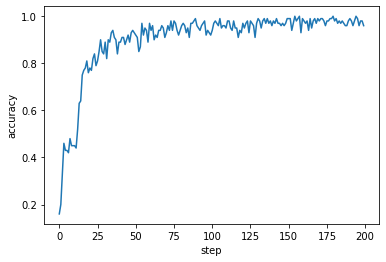

In [48]:
plt.plot(Accc)
plt.xlabel('step')
plt.ylabel('accuracy')

In [49]:
pred = conv_net_2(x_test)
loss = cross_entropy(pred,y_test)
acc = accuracy_2(pred, y_test)
print(float(acc))

0.9767000079154968


In [3]:
#cifar10    multiple channel
from tensorflow.keras.datasets import cifar10

In [21]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(128).prefetch(1)

num_classes = 10

learning_rate = 0.001
training_steps = 5000
display_step = 100

conv1_filters = 32 # number of filters for 1st conv layer.
conv2_filters = 64 # number of filters for 2nd conv layer.
fc1_units = 3072 # number of neurons for 1st fully-connected layer.

random_normal = tf.initializers.RandomNormal()

weights = {
    # Conv Layer 1: 5x5 conv, 3 input, 32 filters (It has 3 color channels).
    'wc1': tf.Variable(random_normal([5, 5, 3, conv1_filters])),
    # Conv Layer 2: 5x5 conv, 32 inputs, 64 filters.
    'wc2': tf.Variable(random_normal([5, 5, conv1_filters, conv2_filters])),
    # FC Layer 1: 8*8*64 inputs, 3072 units.
    'wd1': tf.Variable(random_normal([8*8*64, fc1_units])),
    # FC Out Layer: 3072 inputs, 10 units (total number of classes)
    'out': tf.Variable(random_normal([fc1_units, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([conv1_filters])),
    'bc2': tf.Variable(tf.zeros([conv2_filters])),
    'bd1': tf.Variable(tf.zeros([fc1_units])),
    'out': tf.Variable(tf.zeros([num_classes]))
}
def conv_net_cifar(x):
    x = tf.reshape(x, [-1, 32, 32, 3])                                       # Input shape: [-1, 32, 32, 3].
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])                         #Output shape: [-1, 32, 32, 32].
    conv1 = maxpool2d(conv1, k=2)                                            #Output shape: [-1, 16, 16, 32].
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])   #Output shape: [-1, 8*8*64].
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])              #Output shape: [-1, 3072].
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, rate = 0.2 )
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out']) 
    return tf.nn.softmax(out)

def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy_3(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

optimizer = tf.optimizers.Adam(learning_rate=0.001)

def run_optimization_3(x, y):
    with tf.GradientTape() as g:
        pred = conv_net_cifar(x)
        loss = cross_entropy(pred, y)
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

Accc = []
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization_3(batch_x,tf.transpose(batch_y)[0])
    
    pred = conv_net_cifar(batch_x)
    acc = accuracy_3(pred, tf.transpose(batch_y)[0])
    Accc.append(float(acc))
    
    if step % display_step == 0:
        
        loss = cross_entropy(pred, tf.transpose(batch_y)[0])
        #acc = accuracy_3(pred, tf.transpose(batch_y)[0])
        #Accc.append(float(acc))
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 201.181824, accuracy: 0.484375
step: 200, loss: 170.882416, accuracy: 0.539062
step: 300, loss: 168.729111, accuracy: 0.507812
step: 400, loss: 154.055695, accuracy: 0.554688
step: 500, loss: 120.432686, accuracy: 0.625000
step: 600, loss: 146.830231, accuracy: 0.585938
step: 700, loss: 133.795807, accuracy: 0.656250
step: 800, loss: 98.081802, accuracy: 0.703125
step: 900, loss: 108.775497, accuracy: 0.703125
step: 1000, loss: 104.802124, accuracy: 0.734375
step: 1100, loss: 95.233887, accuracy: 0.726562
step: 1200, loss: 86.849838, accuracy: 0.734375
step: 1300, loss: 89.910553, accuracy: 0.789062
step: 1400, loss: 91.884285, accuracy: 0.781250
step: 1500, loss: 71.732651, accuracy: 0.835938
step: 1600, loss: 62.476662, accuracy: 0.812500
step: 1700, loss: 59.007217, accuracy: 0.828125
step: 1800, loss: 56.434513, accuracy: 0.882812
step: 1900, loss: 44.512283, accuracy: 0.890625
step: 2000, loss: 63.103157, accuracy: 0.835938
step: 2100, loss: 37.414383, accuracy: 0

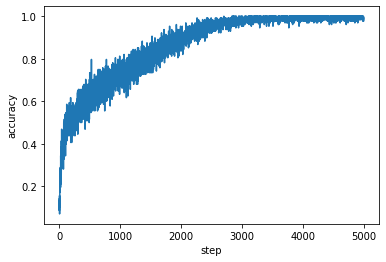

In [25]:
import matplotlib.pyplot as plt
plt.plot(Accc)
plt.xlabel('step')
plt.ylabel('accuracy')
plt.savefig('cifar10_CNN_Accuracy.jpg')

In [26]:
pred = conv_net_cifar(x_test)
loss = cross_entropy(pred, tf.transpose(y_test)[0])
acc = accuracy_3(pred, tf.transpose(y_test)[0])
print(float(acc))

0.6912999749183655


To implement the algorithm that replacing the soft-max layer with a linear support vector machine, we took several steps as following:
# 1 
We tried two different methods to construct DNN and CNN model. 

One of them is to use keras api to create a keras model. It is a stable and efficient way to implement neural network. However, there is no SVM model for DNN or CNN in keras and it is impossible for us to replace the softmax layer with the SVM layer. Even we try to define the SVM by ourselves to match the requests, we still fail to obtain the loss and the expression of weights and biases. So, we try the second method[1]: Constructing the NN model by defining each layer, loss function, and optimizer process. 

In normal CNN model, the last layer is the softmax function and the output is the probability of each class:
![](http://latex.codecogs.com/gif.latex?\\p_i = \frac{exp(a_i)}{\sum_{j}exp(a_j)})
and the predicted class 
![](http://latex.codecogs.com/gif.latex?\\hat{i})
![](http://latex.codecogs.com/gif.latex?\\hat{i} = \text{arg} \max p_i)
We use cross-entropy loss here.

With Support Vector Machines, we delete the softmax layer and output the result from the last layer(Attention: No biases). Then, we define the soft margin loss[2]:
![](http://latex.codecogs.com/gif.latex?\\min_w w^Tw + C\sum_{n=1}^{N}\max(1-w^T x_n y_n,0)^2)
Actually, the primal form is L1_SVM with the standard hinge loss. But it is not differetiable so we use L2-SVM instead. 

To predict the class of data:
![](http://latex.codecogs.com/gif.latex?\\hat{i} = \text{arg}_y \max (w^Tx)y)
Here we only use linear SVM. 

# 2
To implement Multiclass SVM, we use one-vs-rest approach. For K class problems, K linear SVMs are trained independently. The output of the k-th SVM is
![](http://latex.codecogs.com/gif.latex?\a_k(x) = w^Tx)
and the predicted class is
![](http://latex.codecogs.com/gif.latex?\\text{arg}_k \max a_k(x))

# 3
We also meet the problem that the graph is colorful. In this case, we consider one more parameter in our model, channel. If the data has k color channels,then we need k times parameters at the beginning. Actually, there are no much difference between the black-white data and colorful data. In implement this model for CIFAR-10 dataset.